# RTT Analysis Notebook

This notebook analyzes Retraining To Threshold (RTT) results by:
1. Discovering model checkpoints (A: Unlearned, B: Unlearn+RTT, C: Baseline+RTT)
2. Evaluating models on forget and retain sets
3. Matching B and C runs by RTT signature
4. Computing recovery rates (B/C)
5. Generating summary statistics and visualizations


In [4]:
import os
import json
from typing import Optional, Dict, List, Tuple, Union
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import pipeline modules
import sys
sys.path.insert(0, '.')

from pipeline import (
    Datasets, UnlearnType, LossType, DataFormat,
    datasets_dict, compute_rtt_signature, resolve_dataset_dict_paths
)
import unlearn_corpus

# Configuration
MODELS_DIR = "models"
DATA_ROOT = os.getenv("UNLEARN_DATA_ROOT", "data")
WANDB_PROJECT_NAME = None  # Set to filter by project, or None for all
RUN_NAME = "2025-12-28_04-32-08"  # Set to filter by run_name folder, or None for all runs
ACC_SELECTION_RULE = "final_epoch"  # "final_epoch" or "max_epoch"


## 1. Discover Model Checkpoints

Scan the `models/` directory to find all checkpoints for:
- **A (Unlearned)**: `models/{run_name}/{method}/{dataset}/{project}/rank{rank}-sc{sc}-{model_id}-rc{rc}-lr{lr}-epochs{epochs}/`
- **B (Unlearn+RTT)**: `models/{run_name}/fted/{method}/{dataset}/{project}/{loss_type}/ft-skip_split{skip}/lr{lr}-epoch{epochs}/`
- **C (Baseline+RTT)**: `models/{run_name}/baseline_rtt/{dataset}/{model_id}/{loss_type}/skip_split{skip}/lr{lr}-epoch{epochs}/`

Note: If `RUN_NAME` is set to `None`, the notebook will search all subdirectories in `models/` to find checkpoints.


In [5]:
# Discover checkpoints from manifest files

def discover_checkpoints(
    models_dir: str = MODELS_DIR,
    project_filter: Optional[str] = None,
    run_name: Optional[str] = None
) -> Dict[str, List[Dict]]:
    """Discover all model checkpoints by reading from manifest files.
    
    Args:
        models_dir: Root directory containing model checkpoints
        project_filter: Filter by wandb project name (None for all)
        run_name: Filter by run_name folder (None for all runs)
    
    Returns:
        Dictionary with keys "A", "B", "C" containing lists of checkpoint info dicts
    """
    checkpoints = {"A": [], "B": [], "C": []}
    
    # Find all manifest files
    if run_name:
        manifest_path = os.path.join(models_dir, run_name, "manifest.json")
        if not os.path.exists(manifest_path):
            raise FileNotFoundError(f"Manifest not found: {manifest_path}")
        manifest_paths = [manifest_path]
    else:
        # Find all run directories with manifests
        manifest_paths = []
        if not os.path.exists(models_dir):
            raise FileNotFoundError(f"Models directory does not exist: {models_dir}")
        
        for run_dir in os.listdir(models_dir):
            manifest_path = os.path.join(models_dir, run_dir, "manifest.json")
            if os.path.exists(manifest_path):
                manifest_paths.append(manifest_path)
        
        if not manifest_paths:
            raise FileNotFoundError(f"No manifest files found in {models_dir}")
    
    # Load all manifest entries
    all_entries = []
    for manifest_path in manifest_paths:
        with open(manifest_path, 'r') as f:
            entries = json.load(f)
            all_entries.extend(entries)
    
    # Filter by project if specified
    if project_filter:
        all_entries = [e for e in all_entries if e.get("project") == project_filter]
    
    # Group by type
    for entry in all_entries:
        entry_type = entry.get("type")
        if entry_type in checkpoints:
            checkpoints[entry_type].append(entry)
    
    return checkpoints


# Discover checkpoints
checkpoints = discover_checkpoints(
    models_dir=MODELS_DIR,
    project_filter=WANDB_PROJECT_NAME,
    run_name=RUN_NAME
)

print(f"Found {len(checkpoints['A'])} A (Unlearned) checkpoints")
print(f"Found {len(checkpoints['B'])} B (Unlearn+RTT) checkpoints")
print(f"Found {len(checkpoints['C'])} C (Baseline+RTT) checkpoints")


def extract_lora_ranks(checkpoints_list: List[Dict]) -> List[int]:
    """Extract unique LoRA ranks from a list of checkpoints.
    
    Args:
        checkpoints_list: List of checkpoint dictionaries
    
    Returns:
        Sorted list of unique LoRA ranks
    """
    lora_ranks = [cp["lora_rank"] for cp in checkpoints_list if cp.get("lora_rank") is not None]
    return sorted(set(lora_ranks)) if lora_ranks else []


if checkpoints["A"]:
    lora_ranks = extract_lora_ranks(checkpoints["A"])
    if lora_ranks:
        print(f"LoRA ranks in A checkpoints: {lora_ranks}")

if checkpoints["B"]:
    lora_ranks = extract_lora_ranks(checkpoints["B"])
    if lora_ranks:
        print(f"LoRA ranks in B checkpoints: {lora_ranks}")

# Print examples
if checkpoints["A"]:
    example_a = checkpoints["A"][0]
    print(f"\nExample A checkpoint: {example_a['path']}")
    print(f"  Parsed: method={example_a.get('method')}, dataset={example_a.get('dataset')}, "
          f"lora_rank={example_a.get('lora_rank')}, model_id={example_a.get('model_id')}")

if checkpoints["B"]:
    example_b = checkpoints["B"][0]
    print(f"\nExample B checkpoint: {example_b['path']}")
    print(f"  Parsed: method={example_b.get('method')}, dataset={example_b.get('dataset')}, "
          f"loss_type={example_b.get('loss_type')}")

if checkpoints["C"]:
    example_c = checkpoints["C"][0]
    print(f"\nExample C checkpoint: {example_c['path']}")
    print(f"  Parsed: dataset={example_c.get('dataset')}, model_id={example_c.get('model_id')}, "
                    f"loss_type={example_c.get('loss_type')}")


Found 4 A (Unlearned) checkpoints
Found 4 B (Unlearn+RTT) checkpoints
Found 1 C (Baseline+RTT) checkpoints
LoRA ranks in A checkpoints: [2, 4]
LoRA ranks in B checkpoints: [2, 4]

Example A checkpoint: models/2025-12-28_04-32-08/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1
  Parsed: method=LORA, dataset=YEARS, lora_rank=2, model_id=Qwen/Qwen2.5-3B-Instruct

Example B checkpoint: models/2025-12-28_04-32-08/fted/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1/full_pipeline_test/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-07-epoch1-epoch1
  Parsed: method=LORA, dataset=YEARS, loss_type=QUESTION_LETTER_ANSWER

Example C checkpoint: models/2025-12-28_04-32-08/baseline_rtt/YEARS/Qwen_Qwen2.5-3B-Instruct/QUESTION_LETTER_ANSWER/skip_split4/lr1e-07-epoch1-epoch1
  Parsed: dataset=YEARS, model_id=Qwen/Qwen2.5-3B-Instruct, loss_type=QUESTION_LETTER_ANSWER


## 2. Evaluate Models

For each checkpoint, evaluate on forget and retain sets using `unlearn_corpus.just_eval()`.


In [6]:
# Import types needed for this cell
from typing import Optional, Dict

def get_dataset_enum(dataset_name: str) -> Optional[Datasets]:
    """Convert dataset name string to Datasets enum."""
    try:
        return Datasets[dataset_name]
    except KeyError:
        return None


def evaluate_checkpoint(
    checkpoint_info: Dict,
    data_root: str = DATA_ROOT,
    val_batch_size: int = 8,
    attn_backend: Optional[str] = None,
) -> Optional[Dict]:
    """Evaluate a single checkpoint on forget and retain sets.
    
    Returns:
        Dictionary with evaluation metrics or None if evaluation fails
    """
    try:
        dataset_enum = get_dataset_enum(checkpoint_info["dataset"])
        if dataset_enum is None:
            print(f"Warning: Unknown dataset {checkpoint_info['dataset']}")
            return None
        
        # Get dataset paths
        dataset_dict = datasets_dict.get(dataset_enum)
        if dataset_dict is None:
            print(f"Warning: No dataset dict for {dataset_enum}")
            return None
        
        resolved_dict = resolve_dataset_dict_paths(dataset_dict, data_root)
        
        val_files = resolved_dict.get("val_files", [])
        val_retain_files = resolved_dict.get("val_retain_files", [])
        dev_file = resolved_dict.get("dev_file", "")
        retain_dev_file = resolved_dict.get("retain_dev_file", "")
        
        if not val_files:
            print(f"Warning: No val_files for {checkpoint_info['path']}")
            return None
        
        # Determine model path
        model_path = checkpoint_info["path"]
        base_model = checkpoint_info.get("model_id", "")
        
        # Determine unlearn type
        # For A models, use the actual method; for B/C models (fine-tuned), use GD as a default
        # Note: LORA is a model configuration, not a training method, so LORA models use GD training logic
        if checkpoint_info["type"] == "A":
            method = checkpoint_info["method"]
            # LORA models use GD training logic (LORA is just the adapter configuration)
            if method == "LORA":
                unlearn_type = UnlearnType.GD
            else:
                try:
                    unlearn_type = UnlearnType[method]
                except KeyError:
                    # Fallback to GD if method name doesn't match
                    unlearn_type = UnlearnType.GD
        else:
            # For B and C models (fine-tuned), use GD as default since we're only evaluating
            unlearn_type = UnlearnType.GD
        
        # Determine loss type for evaluation (use MCQ format for evaluation)
        loss_type = LossType.LETTER  # Default for MCQ evaluation
        data_format = DataFormat.MCQ
        
        # Call main with just_eval=True (not the Ray remote version)
        result = unlearn_corpus.main(
            train_files=[],  # Not needed for evaluation
            wrong_unlearn_files=[],
            fixed_wrong_unlearn_files=[],
            val_files=val_files,
            dev_set=dev_file,
            base_model=model_path,
            lr=1e-7,  # Not used for evaluation
            name=model_path,
            data_root=data_root,
            val_batch_size=val_batch_size,
            retain_files=[],
            val_retain_files=val_retain_files,
            retain_dev_file=retain_dev_file,
            just_eval=True,
            disable_wandb=True,
            unlearn_type=unlearn_type,
            data_format=data_format,
            loss_type=loss_type,
            attn_backend=attn_backend,
        )
        
        # Extract metrics from result
        (
            save_name,
            forget_accs, forget_accs_calibrated, forget_logits_dict,
            retain_accs, retain_accs_calibrated, retain_logits_dict,
            retain_accs_5_shot, retain_accs_5_shot_calibrated,
            retain_logits_5_shot_dict,
            samples
        ) = result
        
        result = {
            **checkpoint_info,
            "forget_accs": forget_accs,
            "forget_accs_calibrated": forget_accs_calibrated,
            "forget_logits_dict": forget_logits_dict,
            "retain_accs": retain_accs,
            "retain_accs_calibrated": retain_accs_calibrated,
            "retain_logits_dict": retain_logits_dict,
            "retain_accs_5_shot": retain_accs_5_shot,
            "retain_accs_5_shot_calibrated": retain_accs_5_shot_calibrated,
            "retain_logits_5_shot_dict": retain_logits_5_shot_dict,
            "samples": samples,
        }
        
        # Debug: Verify that lr and epochs are preserved for C checkpoints
        if checkpoint_info.get("type") == "C":
            input_lr = checkpoint_info.get("lr")
            input_epochs = checkpoint_info.get("epochs")
            output_lr = result.get("lr")
            output_epochs = result.get("epochs")
            if input_lr != output_lr or input_epochs != output_epochs:
                print(f"WARNING: evaluate_checkpoint lost values for C checkpoint:")
                print(f"  Path: {checkpoint_info.get('path')}")
                print(f"  Input: lr={input_lr}, epochs={input_epochs}")
                print(f"  Output: lr={output_lr}, epochs={output_epochs}")
        
        return result
    except Exception as e:
        print(f"Error evaluating {checkpoint_info.get('path', 'unknown')}: {e}")
        import traceback
        traceback.print_exc()
        return None


def evaluate_baseline_model(
    model_id: str,
    dataset_enum: Datasets,
    data_root: str = DATA_ROOT,
    val_batch_size: int = 8,
    attn_backend: Optional[str] = None,
) -> Optional[Dict]:
    """Evaluate baseline (original) model from HuggingFace on forget and retain sets."""
    try:
        dataset_dict = datasets_dict.get(dataset_enum)
        if dataset_dict is None:
            print(f"Warning: No dataset dict for {dataset_enum}")
            return None
        
        resolved_dict = resolve_dataset_dict_paths(dataset_dict, data_root)
        val_files = resolved_dict.get("val_files", [])
        val_retain_files = resolved_dict.get("val_retain_files", [])
        dev_file = resolved_dict.get("dev_file", "")
        retain_dev_file = resolved_dict.get("retain_dev_file", "")
        
        if not val_files:
            print(f"Warning: No val_files for baseline {model_id}")
            return None
        
        # Use GD as unlearn_type for baseline evaluation (just loads from train_files which is empty)
        result = unlearn_corpus.main(
            train_files=[],  # Not needed for evaluation
            wrong_unlearn_files=[],
            fixed_wrong_unlearn_files=[],
            val_files=val_files,
            dev_set=dev_file,
            base_model=model_id,  # Load from HuggingFace
            lr=1e-7,  # Not used for evaluation
            name=model_id,
            data_root=data_root,
            val_batch_size=val_batch_size,
            retain_files=[],
            val_retain_files=val_retain_files,
            retain_dev_file=retain_dev_file,
            just_eval=True,
            disable_wandb=True,
            unlearn_type=UnlearnType.GD,
            data_format=DataFormat.MCQ,
            loss_type=LossType.LETTER,
            attn_backend=attn_backend,
        )
        
        # Extract metrics from result
        (
            save_name,
            forget_accs, forget_accs_calibrated, forget_logits_dict,
            retain_accs, retain_accs_calibrated, retain_logits_dict,
            retain_accs_5_shot, retain_accs_5_shot_calibrated,
            retain_logits_5_shot_dict,
            samples
        ) = result
        
        return {
            "type": "Baseline",
            "model_id": model_id,
            "dataset": dataset_enum.name,
            "forget_accs": forget_accs,
            "forget_accs_calibrated": forget_accs_calibrated,
            "forget_logits_dict": forget_logits_dict,
            "retain_accs": retain_accs,
            "retain_accs_calibrated": retain_accs_calibrated,
            "retain_logits_dict": retain_logits_dict,
            "retain_accs_5_shot": retain_accs_5_shot,
            "retain_accs_5_shot_calibrated": retain_accs_5_shot_calibrated,
            "retain_logits_5_shot_dict": retain_logits_5_shot_dict,
            "samples": samples,
        }
    except Exception as e:
        print(f"Error evaluating baseline {model_id} on {dataset_enum.name}: {e}")
        import traceback
        traceback.print_exc()
        return None


# Evaluate all checkpoints (this may take a while)
results = {"A": [], "B": [], "C": [], "Baseline": []}

print("Evaluating A (Unlearned) checkpoints...")
for checkpoint in checkpoints["A"]:
    eval_result = evaluate_checkpoint(checkpoint)
    if eval_result:
        results["A"].append(eval_result)

print(f"\nEvaluating B (Unlearn+RTT) checkpoints...")
for checkpoint in checkpoints["B"]:
    eval_result = evaluate_checkpoint(checkpoint)
    if eval_result:
        # Preserve all parsed hyperparameters from checkpoint_info
        eval_result.update({
            k: v for k, v in checkpoint.items() 
            if k not in eval_result or eval_result.get(k) is None
        })
        results["B"].append(eval_result)

print(f"\nEvaluating C (Baseline+RTT) checkpoints...")
for checkpoint in checkpoints["C"]:
    eval_result = evaluate_checkpoint(checkpoint)
    if eval_result:
        # Preserve all parsed hyperparameters from checkpoint_info
        eval_result.update({
            k: v for k, v in checkpoint.items() 
            if k not in eval_result or eval_result.get(k) is None
        })
        results["C"].append(eval_result)

# Collect unique (model_id, dataset) pairs from A checkpoints for baseline evaluation
print(f"\nCollecting baseline models to evaluate...")
baseline_to_eval = {}
for checkpoint in checkpoints["A"]:
    model_id = checkpoint.get("model_id")
    # If model_id is None, try to extract from path or metadata
    if model_id is None:
        # Try to load from metadata
        metadata = load_model_metadata(checkpoint.get("path", ""))
        if metadata:
            model_id = metadata.get("base_model") or metadata.get("model_id")
        # If still None, try to extract from path
        if model_id is None:
            path = checkpoint.get("path", "")
            # Look for model name patterns in path
            import re
            # Pattern: look for something like Qwen/Qwen2.5-3B-Instruct or just Qwen2.5-3B-Instruct
            path_parts = path.split(os.sep)
            for part in reversed(path_parts):
                if any(x in part.lower() for x in ["qwen", "llama", "mistral", "gemma", "phi"]) or ("/" in part and part.count("/") <= 1):
                    # Check if it looks like a model identifier
                    if re.search(r"[A-Za-z]+[0-9.]+", part) or "/" in part:
                        model_id = part
                        break
    dataset_name = checkpoint.get("dataset")
    if model_id and dataset_name:
        key = (model_id, dataset_name)
        if key not in baseline_to_eval:
            baseline_to_eval[key] = {
                "model_id": model_id,
                "dataset": dataset_name,
            }

print(f"Found {len(baseline_to_eval)} unique baseline models to evaluate")

# Evaluate baseline models
print(f"\nEvaluating Baseline (original) models...")
for (model_id, dataset_name), info in baseline_to_eval.items():
    dataset_enum = get_dataset_enum(dataset_name)
    if dataset_enum:
        print(f"  Evaluating {model_id} on {dataset_name}...")
        baseline_result = evaluate_baseline_model(
            model_id, dataset_enum, data_root=DATA_ROOT, attn_backend=None
        )
        if baseline_result:
            results["Baseline"].append(baseline_result)
    else:
        print(f"  Warning: Unknown dataset {dataset_name}, skipping baseline evaluation")

print(f"\nEvaluation complete:")
print(f"  A: {len(results['A'])}/{len(checkpoints['A'])}")
print(f"  B: {len(results['B'])}/{len(checkpoints['B'])}")
print(f"  C: {len(results['C'])}/{len(checkpoints['C'])}")
print(f"  Baseline: {len(results['Baseline'])}/{len(baseline_to_eval)}")


Evaluating A (Unlearned) checkpoints...


The tokenizer you are loading from 'models/2025-12-28_04-32-08/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The tokenizer you are loading from 'models/2025-12-28_04-32-08/LORA/YEARS/full_pipeline_test/rank4-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.001-epochs1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/LORA/YEARS/full_pipeline_test/rank4-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.001-epochs1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/fted/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1/full_pipeline_test/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-07-epoch1-epoch1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/fted/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.001-epochs1/full_pipeline_test/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-07-epoch1-epoch1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/fted/LORA/YEARS/full_pipeline_test/rank4-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1/full_pipeline_test/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-07-epoch1-epoch1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/fted/LORA/YEARS/full_pipeline_test/rank4-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.001-epochs1/full_pipeline_test/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-07-epoch1-epoch1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

The tokenizer you are loading from 'models/2025-12-28_04-32-08/baseline_rtt/YEARS/Qwen_Qwen2.5-3B-Instruct/QUESTION_LETTER_ANSWER/skip_split4/lr1e-07-epoch1-epoch1' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Forget-eval 0: 0.00it [00:00, ?it/s]

val prompts=: ['When did the following event happen?\nThe First Congo War begins.\nA. 1994\nB. 1995\nC. 1996\nD. 1997\nAnswer:', 'When did the following event happen?\nCreation of the U.S. Central Intelligence Agency.\nA. 1947\nB. 1948\nC. 1949\nD. 1950\nAnswer:', 'When did the following event happen?\nPremiere of the Astro Boy anime, the first to be broadcast overseas.\nA. 1960\nB. 1961\nC. 1962\nD. 1963\nAnswer:', 'When did the following event happen?\nAfter takeoff from Miami, a fire started by improperly handled oxygen canisters in the cargo hold of Atlanta-bound ValuJet Flight 592 causes the Douglas DC-9 to crash in the Florida Everglades, killing all 110 people on board.\nA. 1996\nB. 1997\nC. 1998\nD. 1999\nAnswer:', 'When did the following event happen?\nIndependence of Tuvalu from Britain.\nA. 1977\nB. 1978\nC. 1979\nD. 1980\nAnswer:', 'When did the following event happen?\nKing Zog I is crowned in Albania.\nA. 1925\nB. 1926\nC. 1927\nD. 1928\nAnswer:', 'When did the following 

Retain-eval 0: 0.00it [00:00, ?it/s]

Printing retain batches
retain prompts: ['A researcher tests the problem solving skills of twenty 10-year-old, twenty 20-year-old, and twenty 30-year-old participants for a study on age and problem solving. What research method is this researcher using?\nA. longitudinal\nB. stage\nC. developmental\nD. cross-sectional\nAnswer:', 'Severe anaemia at birth is a feature of what?\nA. Alpha-thalassaemia\nB. Beta-thalassaemia\nC. Hereditary persistence of fetal haemoglobin\nD. Sickle cell disease\nAnswer:', 'The semicircular canals of the inner ear are important for helping a person to maintain\nA. tone quality\nB. melatonin\nC. balance\nD. olfaction\nAnswer:', 'As working people get closer to retirement they are more likely to\nA. Be absent from work\nB. Invest in craft and hobby books\nC. Do some informal planning\nD. Become irritated and anxious\nAnswer:', 'In a healthy person maintaining energy balance in equilibrium (i.e. mathematical equality of energy intake and energy expenditure) is g

## 3. Compute RTT Signatures and Match Results

Match B and C runs by RTT signature, and ensure they're evaluated on the same held-out splits.


In [7]:
def extract_accuracy(
    forget_accs: Dict,
    selection_rule: str = "final_epoch"
) -> Optional[float]:
    """Extract a single accuracy value from forget_accs dict.
    
    Args:
        forget_accs: Dictionary mapping epoch/file to accuracy
        selection_rule: "final_epoch" or "max_epoch"
    """
    if not forget_accs:
        return None
    
    # Handle nested dict structure (forget_accs[file][epoch])
    if isinstance(list(forget_accs.values())[0], dict):
        # Average across files, then select epoch
        file_accs = {}
        for file, epochs_dict in forget_accs.items():
            if selection_rule == "final_epoch":
                file_accs[file] = epochs_dict.get(max(epochs_dict.keys()), 0.0)
            elif selection_rule == "max_epoch":
                file_accs[file] = max(epochs_dict.values())
            else:
                file_accs[file] = epochs_dict.get(selection_rule, 0.0)
        return np.mean(list(file_accs.values()))
    else:
        # Simple dict mapping epoch to accuracy
        if selection_rule == "final_epoch":
            return forget_accs.get(max(forget_accs.keys()), 0.0)
        elif selection_rule == "max_epoch":
            return max(forget_accs.values())
        else:
            return forget_accs.get(selection_rule, 0.0)


def match_b_and_c_results(
    b_results: List[Dict],
    c_results: List[Dict],
    ft_loss_types: List[LossType],
    ft_lrs: List[float],
    ft_epochs_lst: List[int],
    num_ft_splits: int,
    ft_freeze_layers: Optional[List] = None,
    ft_data_format_name: str = "MCQ",
    acc_selection_rule: str = "final_epoch",
) -> List[Dict]:
    """Match B and C results by RTT signature and select best B run per group.
    
    Returns:
        List of matched results with B and C entries
    """
    # Group B results by (method, dataset, loss_type, skip_split)
    b_groups = defaultdict(list)
    for b in b_results:
        key = (
            b.get("method"),
            b.get("dataset"),
            b.get("loss_type"),
            b.get("skip_split"),
            b.get("lora_rank"),  # Include A model's lora_rank
            b.get("retain_coeff"),  # Include A model's retain_coeff
            b.get("a_lr"),  # Include A model's lr
            b.get("a_epochs"),  # Include A model's epochs
        )
        b_groups[key].append(b)
    
    # Select best B run per group (by max forget accuracy)
    best_b = {}
    for key, group in b_groups.items():
        best = max(
            group,
            key=lambda x: extract_accuracy(x.get("forget_accs", {}), acc_selection_rule) or 0.0
        )
        best_b[key] = best
    
    # Match B and C by RTT signature
    matches = []
    print(f"\n{'='*60}")
    print(f"Matching B and C results...")
    print(f"Total B groups: {len(best_b)}")
    print(f"Total C results: {len(c_results)}")
    print(f"{'='*60}\n")
    
    # Debug: Print all B groups to see what we have
    print("B groups:")
    for key, b_result in best_b.items():
        method, dataset, loss_type, skip_split, lora_rank, retain_coeff, a_lr, a_epochs = key
        print(f"  {method}/{dataset}, rank={lora_rank}, rc={retain_coeff}, skip_split={skip_split}, "
              f"lr={b_result.get('lr')}, epochs={b_result.get('epochs')}")
    
    for key, b_result in best_b.items():
        method, dataset, loss_type, skip_split, lora_rank, retain_coeff, a_lr, a_epochs = key
        
        # Normalize loss_type: strip "LossType." prefix if present
        loss_type_normalized = loss_type
        if isinstance(loss_type, str):
            if loss_type.startswith("LossType."):
                loss_type_normalized = loss_type[9:]  # Strip "LossType." prefix
        loss_type_enum = LossType[loss_type_normalized] if isinstance(loss_type_normalized, str) else loss_type_normalized
        
        # Compute RTT signature for this B result
        eval_split_ids = [skip_split] if skip_split is not None else None
        b_lr = b_result.get("lr")
        b_epochs = b_result.get("epochs")
        
        print(f"\nB Result: {method}/{dataset}, loss_type={loss_type_normalized}, skip_split={skip_split}")
        print(f"  Path: {b_result.get('path', 'unknown')}")
        print(f"  B lr={b_lr}, B epochs={b_epochs}")
        print(f"  All B keys: {list(b_result.keys())}")
        
        if b_lr is None or b_epochs is None:
            print(f"  ⚠️  Warning: B result has None lr or epochs, skipping")
            continue
            
        rtt_sig = compute_rtt_signature(
            dataset,
            [loss_type_enum],
            [b_lr],
            [b_epochs],  # Use actual epochs from result, not config
            num_ft_splits,
            ft_freeze_layers,
            ft_data_format_name,
            eval_split_ids=eval_split_ids,
        )
        print(f"  B RTT signature: {rtt_sig}")
        
        # Find matching C result
        matching_c = None
        candidate_count = 0
        for c in c_results:
            # Normalize C's loss_type for comparison
            c_loss_type = c.get("loss_type")
            c_loss_type_normalized = c_loss_type
            if isinstance(c_loss_type, str):
                if c_loss_type.startswith("LossType."):
                    c_loss_type_normalized = c_loss_type[9:]
            
            # Check basic matching criteria
            dataset_match = c.get("dataset") == dataset
            loss_type_match = c_loss_type_normalized == loss_type_normalized
            skip_split_match = c.get("skip_split") == skip_split
            
            if dataset_match and loss_type_match and skip_split_match:
                candidate_count += 1
                # Verify RTT signature matches
                c_lr = c.get("lr")
                c_epochs = c.get("epochs")
                
                print(f"  Candidate C #{candidate_count}:")
                print(f"    Path: {c.get('path', 'unknown')}")
                print(f"    C lr={c_lr}, C epochs={c_epochs}")
                print(f"    All C keys: {list(c.keys())}")
                
                if c_lr is None or c_epochs is None:
                    print(f"    ⚠️  Skipping: C has None lr or epochs")
                    continue  # Skip if C has no lr or epochs
                    
                c_rtt_sig = compute_rtt_signature(
                    dataset,
                    [loss_type_enum],
                    [c_lr],
                    [c_epochs],  # Use actual epochs from result, not config
                    num_ft_splits,
                    ft_freeze_layers,
                    ft_data_format_name,
                    eval_split_ids=eval_split_ids,
                )
                print(f"    C RTT signature: {c_rtt_sig}")
                print(f"    Match: {c_rtt_sig == rtt_sig}")
                
                if c_rtt_sig == rtt_sig:
                    matching_c = c
                    print(f"    ✅ MATCH FOUND!")
                    break
            elif dataset_match or loss_type_match or skip_split_match:
                # Partial match - debug why it didn't fully match
                if candidate_count == 0:  # Only print first partial match to avoid spam
                    print(f"  ⚠️  Partial match found but criteria don't all match:")
                    print(f"    dataset: {c.get('dataset')} == {dataset}? {dataset_match}")
                    print(f"    loss_type: {c_loss_type_normalized} == {loss_type_normalized}? {loss_type_match}")
                    print(f"    skip_split: {c.get('skip_split')} == {skip_split}? {skip_split_match}")
        
        if matching_c:
            print(f"  ✅ Found matching C result!")
        else:
            if candidate_count == 0:
                print(f"  ❌ No C candidates found (no matches on basic criteria)")
            else:
                print(f"  ❌ Found {candidate_count} C candidates but RTT signatures didn't match")
        
        if matching_c:
            matches.append({
                "B": b_result,
                "C": matching_c,
                "rtt_signature": rtt_sig,
                "method": method,
                "dataset": dataset,
                "loss_type": loss_type,
                "skip_split": skip_split,
            })
    
    return matches


# Match B and C results
# Note: You may need to adjust these parameters based on your experiment config
FT_LOSS_TYPES = [LossType.QUESTION_LETTER_ANSWER]  # Adjust as needed
FT_LRS = [1e-6, 5e-6]  # Adjust as needed
FT_EPOCHS_LST = [6]  # Adjust as needed
NUM_FT_SPLITS = 2  # Adjust as needed
FT_FREEZE_LAYERS = None
FT_DATA_FORMAT_NAME = "MCQ"

matches = match_b_and_c_results(
    results["B"],
    results["C"],
    FT_LOSS_TYPES,
    FT_LRS,
    FT_EPOCHS_LST,
    NUM_FT_SPLITS,
    FT_FREEZE_LAYERS,
    FT_DATA_FORMAT_NAME,
    acc_selection_rule=ACC_SELECTION_RULE,
)

print(f"Matched {len(matches)} B/C pairs")

# Debug: Print B and C result details if no matches found
if len(matches) == 0:
    print("\n=== Debug: No matches found ===")
    print(f"\nB results ({len(results['B'])} total):")
    for i, b in enumerate(results['B'][:3]):  # Show first 3
        print(f"  B[{i}]: dataset={b.get('dataset')}, loss_type={b.get('loss_type')}, "
              f"skip_split={b.get('skip_split')}, lr={b.get('lr')}, epochs={b.get('epochs')}")
    
    print(f"\nC results ({len(results['C'])} total):")
    for i, c in enumerate(results['C'][:3]):  # Show first 3
        print(f"  C[{i}]: dataset={c.get('dataset')}, loss_type={c.get('loss_type')}, "
              f"skip_split={c.get('skip_split')}, lr={c.get('lr')}, epochs={c.get('epochs')}")
    
    # Check if there are any potential matches by basic criteria
    print("\n=== Checking basic matching criteria ===")
    for b in results['B'][:2]:
        b_loss_type = b.get('loss_type')
        if isinstance(b_loss_type, str) and b_loss_type.startswith("LossType."):
            b_loss_type = b_loss_type[9:]
        print(f"\nB: dataset={b.get('dataset')}, loss_type={b_loss_type}, skip_split={b.get('skip_split')}")
        for c in results['C'][:2]:
            c_loss_type = c.get('loss_type')
            if isinstance(c_loss_type, str) and c_loss_type.startswith("LossType."):
                c_loss_type = c_loss_type[9:]
            print(f"  vs C: dataset={c.get('dataset')}, loss_type={c_loss_type}, skip_split={c.get('skip_split')}")
            if (b.get('dataset') == c.get('dataset') and 
                b_loss_type == c_loss_type and 
                b.get('skip_split') == c.get('skip_split')):
                print(f"    ✓ Basic criteria match!")
                # Check RTT signature
                try:
                    b_loss_type_enum = LossType[b_loss_type]
                    b_lr_val = b.get('lr')
                    b_epochs_val = b.get('epochs')
                    c_lr_val = c.get('lr')
                    c_epochs_val = c.get('epochs')
                    if b_lr_val is None or b_epochs_val is None or c_lr_val is None or c_epochs_val is None:
                        print(f"    Missing lr/epochs values for RTT sig computation")
                    else:
                        b_rtt_sig = compute_rtt_signature(
                            b.get('dataset'),
                            [b_loss_type_enum],
                            [b_lr_val],
                            [b_epochs_val],  # Use actual epochs from result
                            NUM_FT_SPLITS,
                            FT_FREEZE_LAYERS,
                            FT_DATA_FORMAT_NAME,
                            eval_split_ids=[b.get('skip_split')] if b.get('skip_split') is not None else None,
                        )
                        c_rtt_sig = compute_rtt_signature(
                            c.get('dataset'),
                            [b_loss_type_enum],
                            [c_lr_val],
                            [c_epochs_val],  # Use actual epochs from result
                            NUM_FT_SPLITS,
                            FT_FREEZE_LAYERS,
                            FT_DATA_FORMAT_NAME,
                            eval_split_ids=[c.get('skip_split')] if c.get('skip_split') is not None else None,
                        )
                        print(f"    B RTT sig: {b_rtt_sig}")
                        print(f"    C RTT sig: {c_rtt_sig}")
                        print(f"    RTT sig match: {b_rtt_sig == c_rtt_sig}")
                except Exception as e:
                    print(f"    Error computing RTT sig: {e}")



Matching B and C results...
Total B groups: 4
Total C results: 1

B groups:
  LORA/YEARS, rank=2, rc=1.0, skip_split=4, lr=1e-07, epochs=1
  LORA/YEARS, rank=2, rc=1.0, skip_split=4, lr=1e-07, epochs=1
  LORA/YEARS, rank=4, rc=1.0, skip_split=4, lr=1e-07, epochs=1
  LORA/YEARS, rank=4, rc=1.0, skip_split=4, lr=1e-07, epochs=1

B Result: LORA/YEARS, loss_type=QUESTION_LETTER_ANSWER, skip_split=4
  Path: models/2025-12-28_04-32-08/fted/LORA/YEARS/full_pipeline_test/rank2-sc20-Qwen/Qwen2.5-3B-Instruct-rc1.0-lr0.0001-epochs1/full_pipeline_test/LossType.QUESTION_LETTER_ANSWER/ft-skip_split4/lr1e-07-epoch1-epoch1
  B lr=1e-07, B epochs=1
  All B keys: ['type', 'path', 'timestamp', 'run_name', 'method', 'dataset', 'project', 'model_id', 'lr', 'epochs', 'retain_coeff', 'lora_rank', 'steering_coeff', 'a_path', 'a_lr', 'a_epochs', 'loss_type', 'skip_split', 'forget_accs', 'forget_accs_calibrated', 'forget_logits_dict', 'retain_accs', 'retain_accs_calibrated', 'retain_logits_dict', 'retain_accs_

## 4. Compute Recovery Rates and Generate Summary DataFrame

For each matched B/C pair, compute recovery rate = B/C, and create a summary DataFrame.


In [8]:
def evaluate_baseline_model(
    model_id: str,
    dataset_enum: Datasets,
    data_root: str = DATA_ROOT,
    val_batch_size: int = 8,
    attn_backend: Optional[str] = None,
) -> Optional[Dict]:
    """Evaluate baseline model on forget set."""
    try:
        dataset_dict = datasets_dict.get(dataset_enum)
        if dataset_dict is None:
            return None
        
        resolved_dict = resolve_dataset_dict_paths(dataset_dict, data_root)
        val_files = resolved_dict.get("val_files", [])
        dev_file = resolved_dict.get("dev_file", "")
        
        if not val_files:
            return None
        
        result = unlearn_corpus.main(
            train_files=[],
            wrong_unlearn_files=[],
            fixed_wrong_unlearn_files=[],
            val_files=val_files,
            dev_set=dev_file,
            base_model=model_id,
            lr=1e-7,
            name=model_id,
            data_root=data_root,
            val_batch_size=val_batch_size,
            retain_files=[],
            val_retain_files=[],
            retain_dev_file="",
            just_eval=True,
            disable_wandb=True,
            data_format=DataFormat.MCQ,
            loss_type=LossType.LETTER,
            attn_backend=attn_backend,
        )
        
        (
            save_name,
            forget_accs, forget_accs_calibrated, forget_logits_dict,
            retain_accs, retain_accs_calibrated, retain_logits_dict,
            retain_accs_5_shot, retain_accs_5_shot_calibrated,
            retain_logits_5_shot_dict,
            samples
        ) = result
        
        return {
            "forget_accs": forget_accs,
            "forget_accs_calibrated": forget_accs_calibrated,
            "forget_logits_dict": forget_logits_dict,
        }
    except Exception as e:
        print(f"Error evaluating baseline {model_id}: {e}")
        return None


def create_summary_dataframe(
    a_results: List[Dict],
    matches: List[Dict],
    baseline_results: Optional[List[Dict]] = None,
    acc_selection_rule: str = "final_epoch",
    evaluate_baseline: bool = False,  # Now False by default since we evaluate separately
    data_root: str = DATA_ROOT,
) -> pd.DataFrame:
    """Create summary DataFrame with A/B/C metrics and recovery rates."""
    rows = []
    
    # Cache baseline evaluations
    baseline_cache = {}
    
    for match in matches:
        b_result = match["B"]
        c_result = match["C"]
        
        # Find corresponding A result
        # Match by method, dataset, project, lora_rank, retain_coeff, lr, and epochs
        # Use metadata fields if available, otherwise extract from path
        a_result = None
        b_lora_rank = b_result.get("lora_rank")
        b_retain_coeff = b_result.get("retain_coeff")  # From metadata (A model's retain_coeff)
        b_a_lr = b_result.get("a_lr")  # From metadata (A model's lr)
        b_a_epochs = b_result.get("a_epochs")  # From metadata (A model's epochs)
        
        # If metadata not available, try to extract from path as fallback
        if b_retain_coeff is None or b_a_lr is None or b_a_epochs is None:
            b_path = b_result.get("path", "")
            ft_split_idx = b_path.find("/ft-skip_split")
            if ft_split_idx > 0:
                a_model_part = b_path[:ft_split_idx]
                rc_match = re.search(r"-rc([\d.e-]+)-lr([\d.e-]+)-epochs(\d+)", a_model_part)
                if rc_match:
                    try:
                        if b_retain_coeff is None:
                            b_retain_coeff = float(rc_match.group(1))
                        if b_a_lr is None:
                            b_a_lr = float(rc_match.group(2))
                        if b_a_epochs is None:
                            b_a_epochs = int(rc_match.group(3))
                    except (ValueError, IndexError):
                        pass
        
        for a in a_results:
            if (
                a.get("method") == b_result.get("method")
                and a.get("dataset") == b_result.get("dataset")
                and a.get("project") == b_result.get("project")
            ):
                # Match lora_rank if available
                lora_rank_match = True
                if b_lora_rank is not None:
                    lora_rank_match = (a.get("lora_rank") == b_lora_rank)
                
                # Match retain_coeff if we have it
                retain_coeff_match = True
                if b_retain_coeff is not None:
                    a_retain_coeff = a.get("retain_coeff")
                    if a_retain_coeff is not None:
                        retain_coeff_match = abs(float(a_retain_coeff) - float(b_retain_coeff)) < 1e-9
                    else:
                        retain_coeff_match = False
                
                # Match lr if we have it (A model's lr, not RTT lr)
                lr_match = True
                if b_a_lr is not None:
                    a_lr = a.get("lr")
                    if a_lr is not None:
                        lr_match = abs(float(a_lr) - float(b_a_lr)) < 1e-9
                    else:
                        lr_match = False
                
                # Match epochs if we have it (A model's epochs, not RTT epochs)
                epochs_match = True
                if b_a_epochs is not None:
                    a_epochs = a.get("epochs")
                    if a_epochs is not None:
                        epochs_match = (int(a_epochs) == int(b_a_epochs))
                    else:
                        epochs_match = False
                
                # All matches must be true
                if lora_rank_match and retain_coeff_match and lr_match and epochs_match:
                    a_result = a
                    break
        
        # Fallback: if no match found and we have lora_rank, try matching without retain_coeff/lr/epochs
        # (for backward compatibility with older data)
        if not a_result and b_lora_rank is not None:
            for a in a_results:
                if (
                    a.get("method") == b_result.get("method")
                    and a.get("dataset") == b_result.get("dataset")
                    and a.get("project") == b_result.get("project")
                    and a.get("lora_rank") == b_lora_rank
                ):
                    a_result = a
                    break
        
        if not a_result:
            # Debug: print why we couldn't find a match
            print(f"Warning: Could not find A result for B result:")
            print(f"  B: method={b_result.get('method')}, dataset={b_result.get('dataset')}, "
                  f"project={b_result.get('project')}, lora_rank={b_lora_rank}")
            print(f"  Available A results:")
            for a in a_results:
                if (a.get("method") == b_result.get("method") 
                    and a.get("dataset") == b_result.get("dataset") 
                    and a.get("project") == b_result.get("project")):
                    print(f"    - lora_rank={a.get('lora_rank')}, path={a.get('path', 'N/A')[:80]}...")
            continue
        
        # Extract accuracies
        forget_acc_unlearn = extract_accuracy(
            a_result.get("forget_accs", {}), acc_selection_rule
        )
        forget_acc_unlearn_rtt = extract_accuracy(
            b_result.get("forget_accs", {}), acc_selection_rule
        )
        forget_acc_baseline_rtt = extract_accuracy(
            c_result.get("forget_accs", {}), acc_selection_rule
        )
        
        # Get baseline accuracy
        dataset_name = b_result.get("dataset")
        model_id = a_result.get("model_id")
        
        forget_acc_baseline = None
        # First try to get from pre-evaluated baseline results
        if baseline_results:
            for baseline in baseline_results:
                if (
                    baseline.get("model_id") == model_id
                    and baseline.get("dataset") == dataset_name
                ):
                    forget_acc_baseline = extract_accuracy(
                        baseline.get("forget_accs", {}), acc_selection_rule
                    )
                    break
        
        # If not found and evaluate_baseline is True, evaluate on the fly (legacy behavior)
        if forget_acc_baseline is None and evaluate_baseline and model_id:
            cache_key = (dataset_name, model_id)
            if cache_key not in baseline_cache:
                dataset_enum = get_dataset_enum(dataset_name)
                if dataset_enum:
                    baseline_result = evaluate_baseline_model(
                        model_id, dataset_enum, data_root=data_root
                    )
                    if baseline_result:
                        baseline_cache[cache_key] = extract_accuracy(
                            baseline_result.get("forget_accs", {}), acc_selection_rule
                        )
            forget_acc_baseline = baseline_cache.get(cache_key)
        
        # Compute recovery rate
        recovery_rate = None
        if (
            forget_acc_unlearn_rtt is not None
            and forget_acc_baseline_rtt is not None
            and forget_acc_baseline_rtt > 0
        ):
            recovery_rate = forget_acc_unlearn_rtt / forget_acc_baseline_rtt
        
        # Count RTT splits
        num_rtt_splits_b = 1  # Each B result is for one skip_split
        num_rtt_splits_c = 1  # Each C result is for one skip_split
        
        row = {
            "dataset": dataset_name,
            "unlearn_type": b_result.get("method"),
            "model_id": model_id,
            "model_path": a_result.get("path"),
            "lora_rank": a_result.get("lora_rank", 0),
            "lr": a_result.get("lr"),
            "epochs": a_result.get("epochs"),
            "retain_coeff": a_result.get("retain_coeff"),
            "steering_coeff": a_result.get("steering_coeff", None),
            "forget_acc_baseline": forget_acc_baseline,
            "forget_acc_unlearn": forget_acc_unlearn,
            "forget_acc_unlearn_rtt": forget_acc_unlearn_rtt,
            "forget_acc_baseline_rtt": forget_acc_baseline_rtt,
            "recovery_rate": recovery_rate,
            "rtt_signature": match.get("rtt_signature"),
            "acc_selection_rule": acc_selection_rule,
            "num_rtt_splits_b": num_rtt_splits_b,
            "num_rtt_splits_c": num_rtt_splits_c,
            "loss_type": match.get("loss_type"),
            "skip_split": match.get("skip_split"),
        }
        rows.append(row)
    
    return pd.DataFrame(rows)


# Create summary DataFrame
summary_df = create_summary_dataframe(
    results["A"],
    matches,
    baseline_results=results.get("Baseline", []),
    acc_selection_rule=ACC_SELECTION_RULE,
    evaluate_baseline=False,  # Use pre-evaluated baseline results
    data_root=DATA_ROOT,
)

print(f"\nSummary DataFrame shape: {summary_df.shape}")
print(f"\nColumns: {list(summary_df.columns)}")
print(f"\nFirst few rows:")
print(summary_df.head())



Summary DataFrame shape: (4, 20)

Columns: ['dataset', 'unlearn_type', 'model_id', 'model_path', 'lora_rank', 'lr', 'epochs', 'retain_coeff', 'steering_coeff', 'forget_acc_baseline', 'forget_acc_unlearn', 'forget_acc_unlearn_rtt', 'forget_acc_baseline_rtt', 'recovery_rate', 'rtt_signature', 'acc_selection_rule', 'num_rtt_splits_b', 'num_rtt_splits_c', 'loss_type', 'skip_split']

First few rows:
  dataset unlearn_type                  model_id  \
0   YEARS         LORA  Qwen/Qwen2.5-3B-Instruct   
1   YEARS         LORA  Qwen/Qwen2.5-3B-Instruct   
2   YEARS         LORA  Qwen/Qwen2.5-3B-Instruct   
3   YEARS         LORA  Qwen/Qwen2.5-3B-Instruct   

                                          model_path  lora_rank      lr  \
0  models/2025-12-28_04-32-08/LORA/YEARS/full_pip...          2  0.0001   
1  models/2025-12-28_04-32-08/LORA/YEARS/full_pip...          2  0.0010   
2  models/2025-12-28_04-32-08/LORA/YEARS/full_pip...          4  0.0001   
3  models/2025-12-28_04-32-08/LORA/YEARS

## 5. Visualizations

Create visualizations for recovery rates, accuracy comparisons, etc.



Total models to plot: 4
LoRA ranks: [np.int64(2), np.int64(4)]



Plotting 4 models:
  LoRA 2
(rc=1.0, lr=1.0e-04, e=1): unlearn=0.634, unlearn+rtt=0.639
  LoRA 2
(rc=1.0, lr=1e-03, e=1): unlearn=0.636, unlearn+rtt=0.635
  LoRA 4
(rc=1.0, lr=1.0e-04, e=1): unlearn=0.635, unlearn+rtt=0.639
  LoRA 4
(rc=1.0, lr=1e-03, e=1): unlearn=0.638, unlearn+rtt=0.639


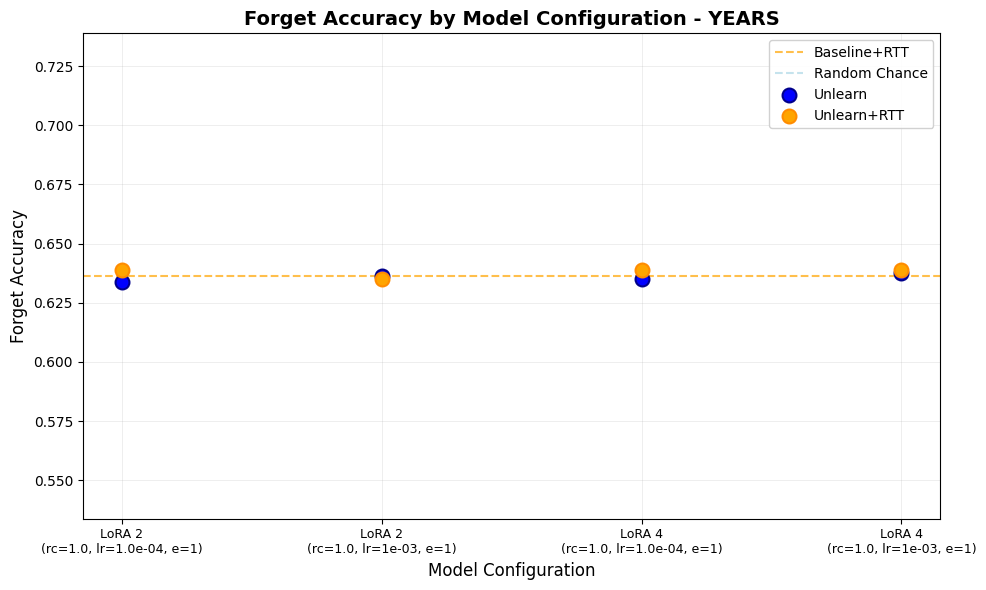

In [9]:
def plot_forget_accuracy_by_lora_rank(
    summary_df: pd.DataFrame,
    dataset_name: Optional[str] = None,
    save_path: Optional[str] = None
):
    """Plot forget accuracy by LoRA rank, similar to the reference image.
    
    Shows:
    - LoRA ranks on x-axis
    - Forget Accuracy on y-axis
    - Unlearn (blue circle) and Unlearn+RTT (orange circle) for each LoRA rank
    - Vertical lines connecting them
    - Horizontal reference lines for Baseline+RTT and Random Chance
    """
    if summary_df.empty:
        print("No data to plot")
        return
    
    # Filter by dataset if specified
    plot_df = summary_df.copy()
    if dataset_name:
        plot_df = plot_df[plot_df["dataset"] == dataset_name]
    
    if plot_df.empty:
        print(f"No data for dataset {dataset_name}")
        return
    
    # Group by LoRA rank and aggregate (take mean if multiple runs per rank)
    if "lora_rank" not in plot_df.columns:
        print("No lora_rank column found. Using all data points.")
        # If no lora_rank, we can't group - just plot all points
        plot_df["lora_rank"] = plot_df.get("lora_rank", 0)
    
    # Don't group - show each model as a separate point
    # Just use the plot_df directly, sorted appropriately
    display_df = plot_df.copy()
    
    # Convert lora_rank to numeric for sorting
    if "lora_rank" in display_df.columns:
        display_df["lora_rank"] = pd.to_numeric(display_df["lora_rank"], errors="coerce")
    
    # Sort by lora_rank, then by other key hyperparameters for consistent ordering
    sort_cols = ["lora_rank"]
    if "retain_coeff" in display_df.columns:
        sort_cols.append("retain_coeff")
    if "lr" in display_df.columns:
        sort_cols.append("lr")
    if "epochs" in display_df.columns:
        sort_cols.append("epochs")
    
    display_df = display_df.sort_values(sort_cols).reset_index(drop=True)
    
    print(f"\nTotal models to plot: {len(display_df)}")
    if "lora_rank" in display_df.columns:
        unique_ranks = sorted([r for r in display_df["lora_rank"].unique() if not pd.isna(r)])
        print(f"LoRA ranks: {unique_ranks}")
    
    # Get baseline+RTT value (should be constant, take first non-null)
    baseline_rtt_val = display_df["forget_acc_baseline_rtt"].dropna()
    if len(baseline_rtt_val) > 0:
        baseline_rtt_val = baseline_rtt_val.iloc[0]
    else:
        baseline_rtt_val = None
    
    # Random chance (assuming 4 choices for MCQ)
    num_choices = 4
    random_chance = 1.0 / num_choices
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot horizontal reference lines
    if baseline_rtt_val is not None:
        ax.axhline(
            y=baseline_rtt_val,
            color="orange",
            linestyle="--",
            linewidth=1.5,
            label="Baseline+RTT",
            alpha=0.7
        )
    
    ax.axhline(
        y=random_chance,
        color="lightblue",
        linestyle="--",
        linewidth=1.5,
        label="Random Chance",
        alpha=0.7
    )
    
    # Create labels for x-axis - include key hyperparameters
    x_labels = []
    for idx, row in display_df.iterrows():
        label_parts = []
        
        # Always include LoRA rank
        if "lora_rank" in row and not pd.isna(row["lora_rank"]):
            label_parts.append(f"LoRA {int(row['lora_rank'])}")
        else:
            label_parts.append("LoRA ?")
        
        # Add other key hyperparameters as second line
        hyperparams = []
        if "retain_coeff" in row and not pd.isna(row.get("retain_coeff")):
            hyperparams.append(f"rc={row['retain_coeff']}")
        if "lr" in row and not pd.isna(row.get("lr")):
            lr_val = row["lr"]
            # Format lr nicely
            if lr_val >= 1e-3:
                hyperparams.append(f"lr={lr_val:.0e}")
            else:
                hyperparams.append(f"lr={lr_val:.1e}")
        if "epochs" in row and not pd.isna(row.get("epochs")):
            hyperparams.append(f"e={int(row['epochs'])}")
        
        if hyperparams:
            label = label_parts[0] + "\n(" + ", ".join(hyperparams) + ")"
        else:
            label = label_parts[0]
        
        x_labels.append(label)
    
    # Get x positions
    x_positions = np.arange(len(display_df))
    
    # Debug: Print what we're plotting
    print(f"\nPlotting {len(display_df)} models:")
    for idx, (_, row) in enumerate(display_df.iterrows()):
        print(f"  {x_labels[idx]}: unlearn={row.get('forget_acc_unlearn', 'N/A'):.3f}, "
              f"unlearn+rtt={row.get('forget_acc_unlearn_rtt', 'N/A'):.3f}")
    
    # Get accuracies
    unlearn_accs = display_df["forget_acc_unlearn"].values if "forget_acc_unlearn" in display_df.columns else []
    unlearn_rtt_accs = display_df["forget_acc_unlearn_rtt"].values if "forget_acc_unlearn_rtt" in display_df.columns else []
    
    # Plot connecting lines (vertical lines with arrows)
    for i, (x, unlearn, unlearn_rtt) in enumerate(zip(x_positions, unlearn_accs, unlearn_rtt_accs)):
        if not (np.isnan(unlearn) or np.isnan(unlearn_rtt)):
            # Draw vertical line
            ax.plot(
                [x, x],
                [unlearn, unlearn_rtt],
                color="gray",
                linewidth=1.5,
                alpha=0.5,
                zorder=1
            )
            # Add arrow at the top
            ax.annotate(
                "",
                xy=(x, unlearn_rtt),
                xytext=(x, unlearn),
                arrowprops=dict(
                    arrowstyle="->",
                    color="gray",
                    lw=1.5,
                    alpha=0.7
                ),
                zorder=1
            )
    
    # Plot Unlearn points (blue circles) - only plot non-NaN values
    valid_unlearn_mask = ~np.isnan(unlearn_accs)
    if np.any(valid_unlearn_mask):
        ax.scatter(
            x_positions[valid_unlearn_mask],
            unlearn_accs[valid_unlearn_mask],
            color="blue",
            s=100,
            marker="o",
            label="Unlearn",
            zorder=2,
            edgecolors="darkblue",
            linewidths=1.5
        )
    
    # Plot Unlearn+RTT points (orange circles) - only plot non-NaN values
    valid_unlearn_rtt_mask = ~np.isnan(unlearn_rtt_accs)
    if np.any(valid_unlearn_rtt_mask):
        ax.scatter(
            x_positions[valid_unlearn_rtt_mask],
            unlearn_rtt_accs[valid_unlearn_rtt_mask],
            color="orange",
            s=100,
            marker="o",
            label="Unlearn+RTT",
            zorder=2,
            edgecolors="darkorange",
            linewidths=1.5
        )
    
    # Set x-axis labels
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=0, ha="center", fontsize=9)
    ax.set_xlabel("Model Configuration", fontsize=12)
    ax.set_ylabel("Forget Accuracy", fontsize=12)
    
    # Set title
    title = f"Forget Accuracy by Model Configuration"
    if dataset_name:
        title += f" - {dataset_name}"
    ax.set_title(title, fontsize=14, fontweight="bold")
    
    # Set y-axis limits
    if len(unlearn_accs) > 0 and len(unlearn_rtt_accs) > 0:
        all_accs = np.concatenate([unlearn_accs, unlearn_rtt_accs])
        all_accs = all_accs[~np.isnan(all_accs)]
        if baseline_rtt_val is not None and not pd.isna(baseline_rtt_val):
            all_accs = np.concatenate([all_accs, [baseline_rtt_val]])
        if len(all_accs) > 0:
            y_min = max(0, min(all_accs) - 0.1)
            y_max = min(1, max(all_accs) + 0.1)
            ax.set_ylim(y_min, y_max)
    
    # Adjust figure width based on number of models
    num_models = len(display_df)
    fig_width = max(10, min(20, num_models * 1.2))
    fig.set_size_inches(fig_width, 6)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle="-", linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Add legend
    ax.legend(loc="best", fontsize=10, framealpha=0.9)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


# Create visualization
if not summary_df.empty:
    # Get unique datasets
    datasets = summary_df["dataset"].unique() if "dataset" in summary_df.columns else [None]
    
    for dataset in datasets:
        plot_forget_accuracy_by_lora_rank(summary_df, dataset_name=dataset)
else:
    print("No data available for visualization")


## 6. Export Results

Save the summary DataFrame to CSV for further analysis.


In [10]:
# Export summary DataFrame
output_path = "evals/pipeline/summary/analysis_results.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
summary_df.to_csv(output_path, index=False)
print(f"Summary DataFrame saved to {output_path}")

# Also save raw results (optional)
results_path = "evals/pipeline/summary/raw_results.json"
with open(results_path, "w") as f:
    json.dump({
        "A": [{k: v for k, v in r.items() if k not in ["forget_logits_dict", "retain_logits_dict", "retain_logits_5_shot_dict"]} for r in results["A"]],
        "B": [{k: v for k, v in r.items() if k not in ["forget_logits_dict", "retain_logits_dict", "retain_logits_5_shot_dict"]} for r in results["B"]],
        "C": [{k: v for k, v in r.items() if k not in ["forget_logits_dict", "retain_logits_dict", "retain_logits_5_shot_dict"]} for r in results["C"]],
        "Baseline": [{k: v for k, v in r.items() if k not in ["forget_logits_dict", "retain_logits_dict", "retain_logits_5_shot_dict"]} for r in results.get("Baseline", [])],
        "matches": matches,
    }, f, indent=2, default=str)
print(f"Raw results saved to {results_path}")


Summary DataFrame saved to evals/pipeline/summary/analysis_results.csv
Raw results saved to evals/pipeline/summary/raw_results.json
